# Modélisation et évaluation des modèles

Ce notebook entraîne et évalue différents modèles de Machine Learning pour la classification de sentiment sur les données de tweets prétraitées.

## 1- Importation des librairies

In [1]:
# Imports standards (bibliothèques intégrées à Python)
import sys
import os
import pickle  # Pour la sauvegarde et le chargement de modèles et d'objets Python

# Manipulation et traitement de données
import pandas as pd
import numpy as np

# Machine Learning
    # Scikit-learn (modèles, métriques, utilitaires)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

    # TensorFlow/Keras (modèles de deep learning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten  # Couches Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences # Pour le padding des séquences
from tensorflow.keras.optimizers.schedules import ExponentialDecay # Pour la décroissance du taux d'apprentissage

    # Hugging Face Transformers (modèles pré-entraînés)
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

     # Gensim (Word2Vec, FastText, Doc2Vec - embeddings)
from gensim.models import Word2Vec, FastText

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# MLflow (suivi des expériences)
import mlflow
import mlflow.sklearn  # Intégration MLflow pour scikit-learn
import mlflow.keras    # Intégration MLflow pour Keras
import tensorflow_hub as hub

# Imports de modules locaux (personnalisés)
sys.path.append('../src')
import model  # Fonctions pour créer les modèles (à remplacer par vos implémentations)
import evaluation  # Fonctions pour évaluer les modèles (à remplacer)


2025-02-09 16:03:43.823659: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-09 16:03:45.398440: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-09 16:03:46.329878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739113427.285101   15087 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739113427.964379   15087 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 16:03:49.731637: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## 2. Chargement des données

In [2]:
#@title 2.1 Chargement des données

# Chemin d'accès au dossier data
data_path = '../data/processed/'

# Charger les données prétraitées

## Données non vectorisées
X_train = pickle.load(open(data_path + 'X_train.pickle', 'rb'))
X_test = pickle.load(open(data_path + 'X_test.pickle', 'rb'))

## Labels
y_train = pickle.load(open(data_path + 'y_train.pickle', 'rb'))
y_test = pickle.load(open(data_path + 'y_test.pickle', 'rb'))

## Vectorisées TF-IDF
X_train_tfidf = pickle.load(open(data_path + 'X_train_tfidf.pickle', 'rb'))
X_test_tfidf = pickle.load(open(data_path + 'X_test_tfidf.pickle', 'rb'))

## Word2vec
X_train_w2v = pickle.load(open(data_path + 'X_train_word2vec.pickle', 'rb'))
X_test_w2v = pickle.load(open(data_path + 'X_test_word2vec.pickle', 'rb'))


## Doc2Vec
X_train_d2v = pickle.load(open(data_path + 'X_train_doc2vec.pickle', 'rb'))
X_test_d2v = pickle.load(open(data_path + 'X_test_doc2vec.pickle', 'rb'))


## 3. Entraînement et évaluation des modèles

### 3.1.1 - Logreg + TFIdf (Baseline)

Accuracy: 0.7582
Precision: 0.7403
Recall: 0.7912
F1-score: 0.7649
Prediction Time: 0.0510 seconds


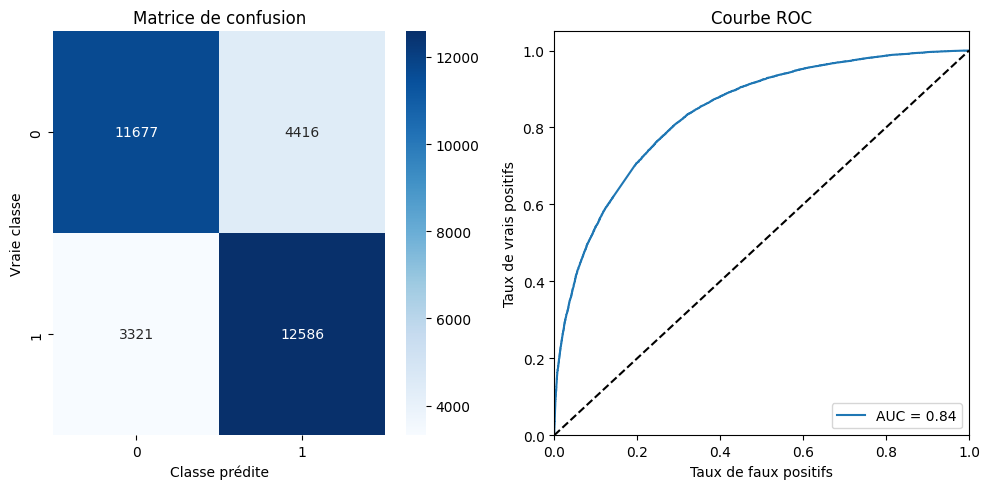

In [5]:
# Créer et entraîner le modèle de régression logistique
model_lr = LogisticRegression(solver='liblinear', max_iter=1000)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_lr.fit(X_train_tfidf, y_train)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lr, X_test_tfidf, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 1000)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)  

    # Ajouter un tag
    mlflow.set_tag("model_name", "LogisticRegression")

    # Enregistrer le modèle avec pickle
    with open('../models/model_lr.pkl', 'wb') as f:
        pickle.dump(model_lr, f)
        
    # Enregistrer le modèle avec mlflow
    mlflow.sklearn.log_model(model_lr,
                             "model_lr",
                            input_example =  X_train_tfidf[:5])

### 3.1.2 - Logreg + Doc2Vec

Accuracy: 0.6959
Precision: 0.6942
Recall: 0.6940
F1-score: 0.6941
Prediction Time: 0.1477 seconds


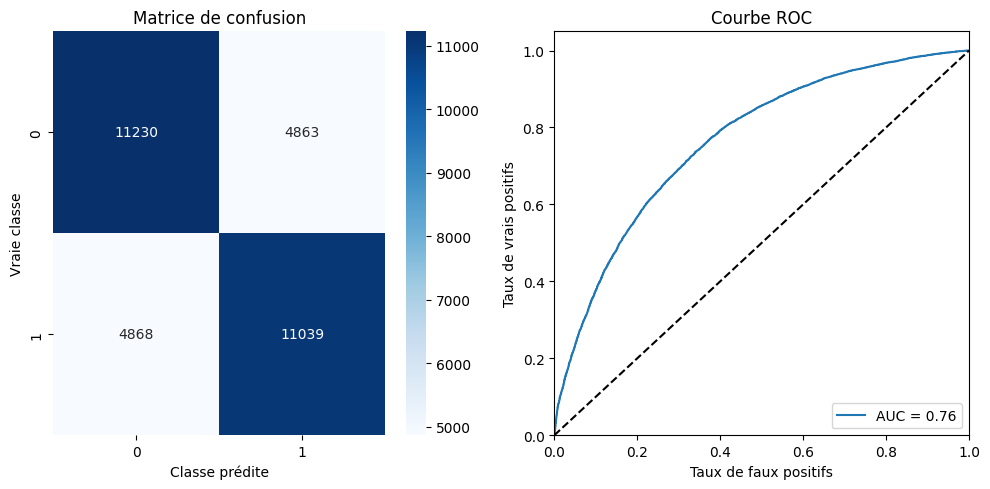

In [6]:

# Créer et entraîner le modèle de régression logistique
model_lr_Doc2vec = LogisticRegression(solver='liblinear',
                                      max_iter=1000)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_lr_Doc2vec.fit(X_train_d2v, y_train)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lr_Doc2vec,
                                                                              X_test_d2v,
                                                                              y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LogisticRegression_Doc2vec")
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 1000)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)  # Enregistrer le predict_time

    # Ajouter un tag
    mlflow.set_tag("model_name", "LogisticRegression_Doc2Vec")

    # Enregistrer le modèle avec mlflow
    mlflow.sklearn.log_model(model_lr_Doc2vec,
                             "model_lr_doc2vec",
                            input_example = X_train_d2v[:5])

### 3.1.3 - Logreg + Word2Vec

Accuracy: 0.7235
Precision: 0.7160
Recall: 0.7356
F1-score: 0.7257
Prediction Time: 0.2646 seconds


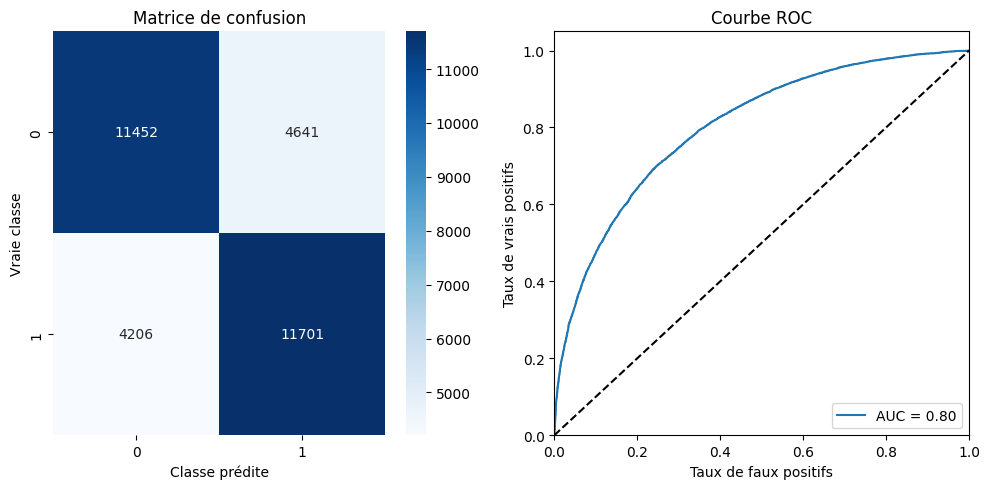

In [9]:
# Créer et entraîner le modèle de régression logistique
model_lr_w2v = LogisticRegression(solver='liblinear',
                                  max_iter=1000)

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_lr_w2v.fit(X_train_w2v, y_train)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lr_w2v,
                                                                       X_test_w2v,
                                                                       y_test)
    except KeyboardInterrupt:
        print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "LogisticRegression_Word2Vec")  # Nom descriptif
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("random_state", 42) # Ajouter le random state

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag
    mlflow.set_tag("model_name", "LogisticRegression_Word2Vec")

    # Enregistrer le modèle avec mlflow
    mlflow.sklearn.log_model(model_lr_w2v,
                             "model_lr_word2vec",
                            input_example = X_train_w2v[:5]) 

### 3.2.1 - MLP + TF-IDF

In [ ]:
# Créer et entraîner le modèle MLP
model_mlp = model.create_mlp_model(input_shape=(X_train_tfidf.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Paramètres
        n_epochs = 10
        batch_size = 8
        # Entraîner le modèle
        model_mlp.fit(X_train_tfidf.toarray(),  # Convertir en array dense
                    y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_mlp,
                                                                                  X_test_tfidf.toarray(),
                                                                                  y_test)

    except KeyboardInterrupt:
         print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "MLP_TFIDF")  # Nom descriptif
    mlflow.log_param("epochs", n_epochs)
    mlflow.log_param("batch_size", batch_size)

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag
    mlflow.set_tag("model_name", "MLP_TFIDF")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_mlp, "model_mlp_tfidf")  # Nom de fichier cohérent


/home/mehdi/Documents/OC/OC7/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1739113482.719878   15087 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 3.2.2 - MLP + Word2Vec

Epoch 1/10
3200/3200 [==============================] - 12s 4ms/step - loss: 0.5848 - accuracy: 0.6911 - val_loss: 0.5724 - val_accuracy: 0.6995
Epoch 2/10
3200/3200 [==============================] - 12s 4ms/step - loss: 0.5657 - accuracy: 0.7046 - val_loss: 0.5655 - val_accuracy: 0.7086
Epoch 3/10
3200/3200 [==============================] - 13s 4ms/step - loss: 0.5563 - accuracy: 0.7113 - val_loss: 0.5628 - val_accuracy: 0.7099
Epoch 4/10
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5501 - accuracy: 0.7160 - val_loss: 0.5575 - val_accuracy: 0.7146
Epoch 5/10
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5439 - accuracy: 0.7205 - val_loss: 0.5589 - val_accuracy: 0.7135
Epoch 6/10
3200/3200 [==============================] - 11s 4ms/step - loss: 0.5396 - accuracy: 0.7240 - val_loss: 0.5582 - val_accuracy: 0.7150
Epoch 7/10
3200/3200 [==============================] - 12s 4ms/step - loss: 0.5354 - accuracy: 0.7254 - val_loss: 0.5568 - val_ac

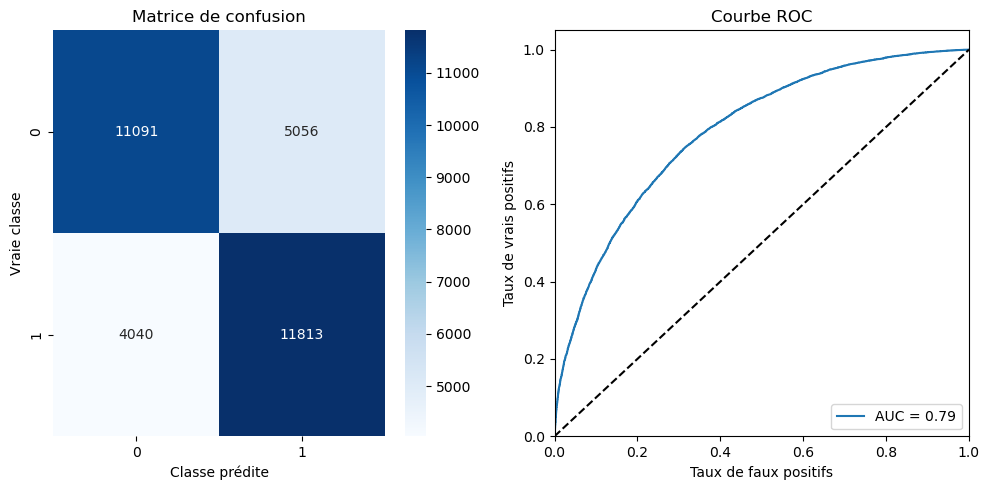

2024/12/22 20:45:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp6xjin5f5/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp6xjin5f5/model/data/model/assets
2024/12/22 20:45:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [4]:
# Créer et entraîner le modèle MLP
model_mlp = model.create_mlp_model(input_shape=(X_train_w2v.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_mlp.fit(X_train_w2v,
                      y_train,
                      epochs=10,
                      batch_size=8,
                      validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_mlp,
                                                                                  X_test_w2v,
                                                                                  y_test)

    except KeyboardInterrupt:
        print("Entrainement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "MLP_Word2Vec") # Nom du modèle descriptif
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 8)
    # Ajoutez d'autres hyperparamètres si vous en avez

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "MLP_Word2Vec")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_mlp, "model_mlp_w2v") 


### 3.3.1 - CNN + TF-IDF

In [ ]:
# Reshape des données TF-IDF pour le CNN (IMPORTANT: conversion en dense + ajout de la dimension canal)
X_train_cnn = X_train_tfidf.toarray()  # Convertit en array dense
X_train_cnn = np.reshape(X_train_cnn, (X_train_cnn.shape[0], X_train_cnn.shape[1], 1))

X_test_cnn = X_test_tfidf.toarray()  # Convertit en array dense
X_test_cnn = np.reshape(X_test_cnn, (X_test_cnn.shape[0], X_test_cnn.shape[1], 1))

# Créer le modèle CNN
model_cnn = create_cnn_model(input_shape=(X_train_cnn.shape[1], 1))  # input_shape correcte

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_cnn.fit(X_train_cnn,
                    y_train,
                    epochs=10,
                    batch_size=8,
                    validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluer_modele(model_cnn, X_test_cnn, y_test)
    except KeyboardInterrupt:
        print("Entrainement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "CNN_TFIDF")  # Nom descriptif
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 8)

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag
    mlflow.set_tag("model_name", "CNN_TFIDF")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_cnn, "model_cnn_tfidf") 


### 3.3.2 - CNN + Word2Vec

Epoch 1/10
3200/3200 [==============================] - 40s 12ms/step - loss: 0.6051 - accuracy: 0.6735 - val_loss: 0.5905 - val_accuracy: 0.6901
Epoch 2/10
3200/3200 [==============================] - 42s 13ms/step - loss: 0.5838 - accuracy: 0.6910 - val_loss: 0.5844 - val_accuracy: 0.6943
Epoch 3/10
3200/3200 [==============================] - 40s 12ms/step - loss: 0.5773 - accuracy: 0.6954 - val_loss: 0.5842 - val_accuracy: 0.6920
Epoch 4/10
3200/3200 [==============================] - 36s 11ms/step - loss: 0.5726 - accuracy: 0.6999 - val_loss: 0.5843 - val_accuracy: 0.6939
Epoch 5/10
3200/3200 [==============================] - 39s 12ms/step - loss: 0.5695 - accuracy: 0.7001 - val_loss: 0.5830 - val_accuracy: 0.6934
Epoch 6/10
3200/3200 [==============================] - 47s 15ms/step - loss: 0.5662 - accuracy: 0.7045 - val_loss: 0.5805 - val_accuracy: 0.6963
Epoch 7/10
3200/3200 [==============================] - 41s 13ms/step - loss: 0.5636 - accuracy: 0.7054 - val_loss: 0.5811 -

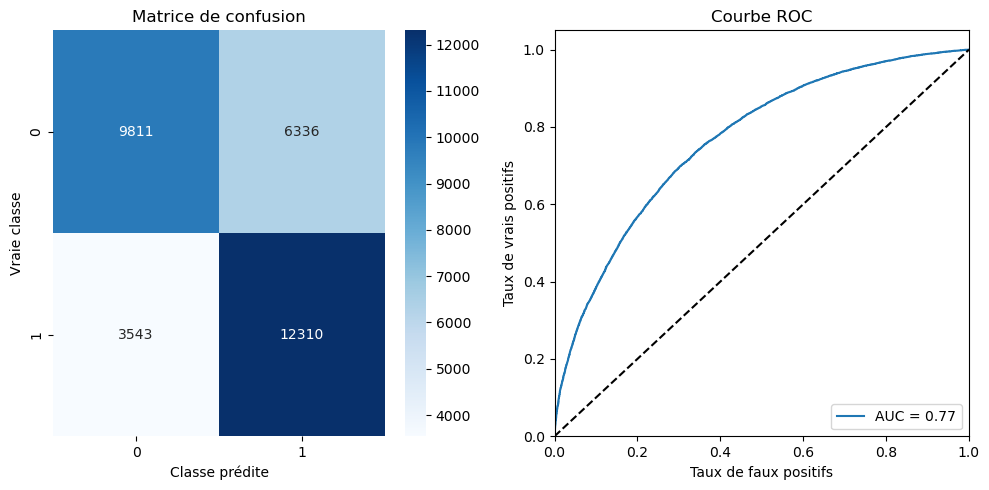

2024/12/22 20:52:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpok5j698h/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpok5j698h/model/data/model/assets
2024/12/22 20:52:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [5]:
# Reshape des données Word2Vec pour le modèle CNN
X_train_cnn = np.reshape(X_train_w2v, (X_train_w2v.shape[0], X_train_w2v.shape[1], 1))
X_test_cnn = np.reshape(X_test_w2v, (X_test_w2v.shape[0], X_test_w2v.shape[1], 1))

# Créer le modèle CNN
model_cnn = model.create_cnn_model(input_shape=(X_train_cnn.shape[1], 1))

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_cnn.fit(X_train_cnn,
                    y_train,
                    epochs=10,
                    batch_size=8,
                    validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_cnn, X_test_cnn, y_test)
    except KeyboardInterrupt:
        print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "CNN_Word2Vec")  # Nom de modèle descriptif
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 8)
    # Enregistrez d'autres hyperparamètres

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "CNN_Word2Vec")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_cnn, "model_cnn_w2v")  # Nom de fichier cohérent


### 3.4 - LSTM + Word2Vec + Optimisation Batch size

Epoch 1/10
6400/6400 [==============================] - 677s 105ms/step - loss: 0.5337 - accuracy: 0.7280 - val_loss: 0.5033 - val_accuracy: 0.7521
Epoch 2/10
6400/6400 [==============================] - 538s 84ms/step - loss: 0.5034 - accuracy: 0.7514 - val_loss: 0.5019 - val_accuracy: 0.7531
Epoch 3/10
6400/6400 [==============================] - 615s 96ms/step - loss: 0.4926 - accuracy: 0.7581 - val_loss: 0.4893 - val_accuracy: 0.7611
Epoch 4/10
6400/6400 [==============================] - 611s 96ms/step - loss: 0.4844 - accuracy: 0.7613 - val_loss: 0.4897 - val_accuracy: 0.7606
Epoch 5/10
6400/6400 [==============================] - 602s 94ms/step - loss: 0.4766 - accuracy: 0.7673 - val_loss: 0.4870 - val_accuracy: 0.7638
Epoch 6/10
6400/6400 [==============================] - 586s 92ms/step - loss: 0.4701 - accuracy: 0.7715 - val_loss: 0.4851 - val_accuracy: 0.7646
Epoch 7/10
6400/6400 [==============================] - 581s 91ms/step - loss: 0.4612 - accuracy: 0.7771 - val_loss: 

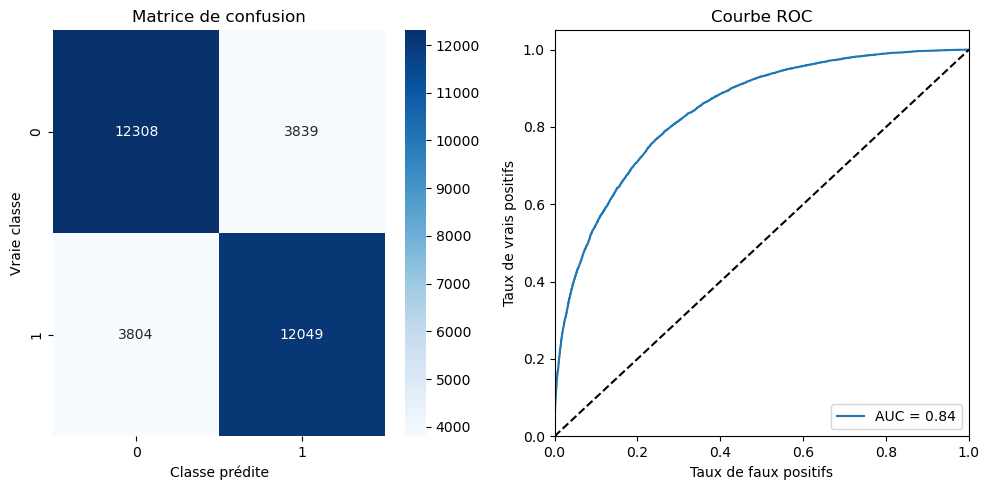

2024/12/22 22:32:39 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpzz06htum/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpzz06htum/model/data/model/assets
2024/12/22 22:32:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Epoch 1/10
3200/3200 [==============================] - 424s 132ms/step - loss: 0.5382 - accuracy: 0.7233 - val_loss: 0.5124 - val_accuracy: 0.7428
Epoch 2/10
3200/3200 [==============================] - 422s 132ms/step - loss: 0.5058 - accuracy: 0.7489 - val_loss: 0.4978 - val_accuracy: 0.7562
Epoch 3/10
3200/3200 [==============================] - 419s 131ms/step - loss: 0.4941 - accuracy: 0.7565 - val_loss: 0.4893 - val_accuracy: 0.7631
Epoch 4/10
3200/3200 [==============================] - 417s 130ms/step - loss: 0.4871 - accuracy: 0.7609 - val_loss: 0.4863 - val_accuracy: 0.7668
Epoch 5/10
3200/3200 [==============================] - 416s 130ms/step - loss: 0.4792 - accuracy: 0.7671 - val_loss: 0.4838 - val_accuracy: 0.7654
Epoch 6/10
3200/3200 [==============================] - 418s 131ms/step - loss: 0.4720 - accuracy: 0.7718 - val_loss: 0.4866 - val_accuracy: 0.7646
Epoch 7/10
3200/3200 [==============================] - 421s 132ms/step - loss: 0.4654 - accuracy: 0.7752 - val_

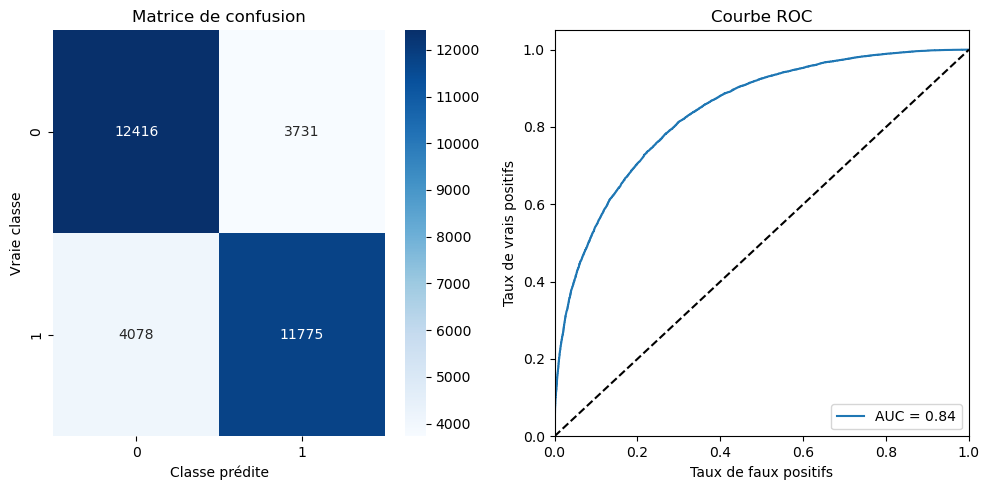

2024/12/22 23:44:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp7fhnl5gp/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp7fhnl5gp/model/data/model/assets
2024/12/22 23:44:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Epoch 1/10
1600/1600 [==============================] - 300s 186ms/step - loss: 0.5439 - accuracy: 0.7196 - val_loss: 0.5202 - val_accuracy: 0.7401
Epoch 2/10
1600/1600 [==============================] - 303s 189ms/step - loss: 0.5117 - accuracy: 0.7462 - val_loss: 0.5038 - val_accuracy: 0.7509
Epoch 3/10
1600/1600 [==============================] - 298s 186ms/step - loss: 0.4993 - accuracy: 0.7528 - val_loss: 0.4993 - val_accuracy: 0.7525
Epoch 4/10
1600/1600 [==============================] - 298s 186ms/step - loss: 0.4915 - accuracy: 0.7581 - val_loss: 0.4922 - val_accuracy: 0.7595
Epoch 5/10
1600/1600 [==============================] - 298s 186ms/step - loss: 0.4840 - accuracy: 0.7622 - val_loss: 0.4897 - val_accuracy: 0.7610
Epoch 6/10
1600/1600 [==============================] - 298s 186ms/step - loss: 0.4775 - accuracy: 0.7677 - val_loss: 0.4853 - val_accuracy: 0.7613
Epoch 7/10
1600/1600 [==============================] - 298s 186ms/step - loss: 0.4701 - accuracy: 0.7715 - val_

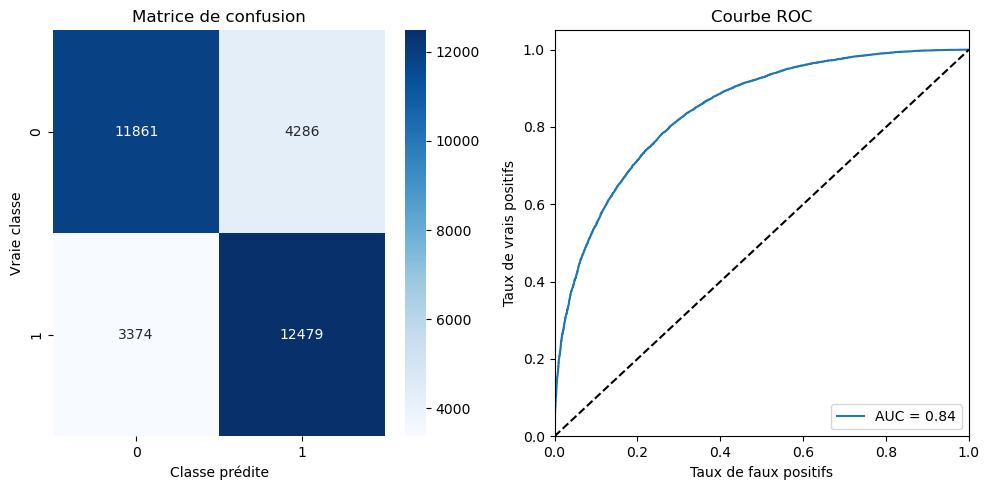

2024/12/23 00:35:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpfkodqatv/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpfkodqatv/model/data/model/assets
2024/12/23 00:35:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Epoch 1/10
800/800 [==============================] - 239s 296ms/step - loss: 0.5513 - accuracy: 0.7136 - val_loss: 0.5252 - val_accuracy: 0.7319
Epoch 2/10
800/800 [==============================] - 234s 292ms/step - loss: 0.5170 - accuracy: 0.7418 - val_loss: 0.5064 - val_accuracy: 0.7487
Epoch 3/10
800/800 [==============================] - 234s 292ms/step - loss: 0.5040 - accuracy: 0.7511 - val_loss: 0.5022 - val_accuracy: 0.7537
Epoch 4/10
800/800 [==============================] - 233s 292ms/step - loss: 0.4944 - accuracy: 0.7560 - val_loss: 0.4910 - val_accuracy: 0.7591
Epoch 5/10
800/800 [==============================] - 234s 293ms/step - loss: 0.4874 - accuracy: 0.7612 - val_loss: 0.4990 - val_accuracy: 0.7534
Epoch 6/10
800/800 [==============================] - 242s 303ms/step - loss: 0.4817 - accuracy: 0.7640 - val_loss: 0.4878 - val_accuracy: 0.7638
Epoch 7/10
800/800 [==============================] - 234s 293ms/step - loss: 0.4758 - accuracy: 0.7678 - val_loss: 0.4889 -

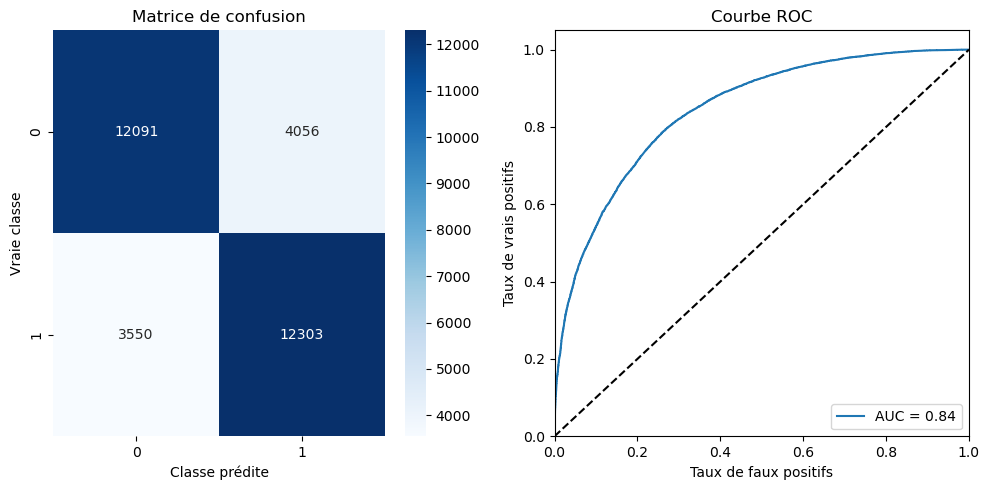

2024/12/23 01:16:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp57hh21ub/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp57hh21ub/model/data/model/assets
2024/12/23 01:16:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Meilleur batch_size : 128


In [6]:
# Entraîner le modèle Word2Vec sur les tweets prétraités
sentences = [tweet.split() for tweet in X_train]
model_w2v = Word2Vec(sentences,
                     vector_size=500,
                     window=5,
                     min_count=1,
                     workers=4)

# Créer la matrice d'embedding
embedding_matrix = np.zeros((len(model_w2v.wv), 500))

# Itérer sur les mots du vocabulaire
for i, word in enumerate(model_w2v.wv.index_to_key):  # Utiliser index_to_key pour obtenir les mots
    embedding_matrix[i] = model_w2v.wv[word]

# Entraîner le modèle sur les données d'entraînement
X_train_w2v = [[model_w2v.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_train]
X_test_w2v = [[model_w2v.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_test]

# Remplir les séquences avec des zéros pour qu'elles aient toutes la même longueur
max_length = 100  # Définir la longueur maximale des séquences
X_train_w2v = pad_sequences(X_train_w2v, maxlen=max_length)
X_test_w2v = pad_sequences(X_test_w2v, maxlen=max_length)

# Définir les valeurs de batch_size à tester
batch_sizes = [16, 32, 64, 128]

# Initialiser le meilleur batch_size et la meilleure accuracy
best_batch_size = None
best_accuracy = 0.0

for batch_size in batch_sizes:
    with mlflow.start_run():
        # Créer le modèle LSTM
        model_lstm = model.create_lstm_model(input_shape=(embedding_matrix.shape[0], embedding_matrix.shape[1]),
                                            embedding_matrix = embedding_matrix)

        # Entraîner le modèle avec le batch_size actuel
        model_lstm.fit(X_train_w2v, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lstm, X_test_w2v, y_test)

        # Enregistrer les paramètres
        mlflow.log_param("model", "LSTM")
        mlflow.log_param("embedding", "Word2Vec")
        mlflow.log_param("epochs", 10)
        mlflow.log_param("batch_size", batch_size)

        # Enregistrer les métriques
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

        # Ajouter un tag pour identifier le modèle
        mlflow.set_tag("model_name", "LSTM_w2v")

        # Enregistrer le modèle
        mlflow.keras.log_model(model_lstm, "model_lstm_w2v")

        # Mettre à jour le meilleur batch_size et la meilleure accuracy si nécessaire
        if accuracy > best_accuracy:
            best_batch_size = batch_size
            best_accuracy = accuracy

# Afficher le meilleur batch_size
print(f"Meilleur batch_size : {best_batch_size}")

### 3.5 - LSTM + FastText

model_ft = FastText(sentences, vector_size=100, window=5, min_count=1, workers=4)

Le code ci-dessus crée un modèle Word2Vec en utilisant la librairie Gensim. Voici une explication des paramètres :

*   `sentences` : une liste de phrases tokenisées qui seront utilisées pour entraîner le modèle.
*   `vector_size` : la dimensionnalité des vecteurs de mots (word embeddings). Ici, chaque mot sera représenté par un vecteur de 100 dimensions.
*   `window` : la taille de la fenêtre de contexte. Le modèle va considérer 5 mots avant et 5 mots après chaque mot pour apprendre les relations entre les mots.
*   `min_count` : le nombre minimum d’occurrences d’un mot pour qu’il soit pris en compte dans le vocabulaire. Ici, tous les mots seront utilisés car `min_count=1`.
*   `workers` : le nombre de cœurs de processeur à utiliser pour l’entraînement.


In [ ]:
#@title 3.7 Entraînement et évaluation du modèle LSTM avec FastText et MLflow

import mlflow
import mlflow.keras
from gensim.models import FastText

# Entraîner le modèle FastText sur les tweets prétraités
sentences = [tweet.split() for tweet in X_train]

vec_size = 500
model_ft = FastText(sentences, 
                    ector_size=vec_size,
                    window=5,
                    min_count=1,
                    workers=4)

# Créer la matrice d'embedding
embedding_matrix = np.zeros((len(model_ft.wv), vec_size))  # Forme (vocab_size, vec_size)

# Itérer sur les mots du vocabulaire
for i, word in enumerate(model_ft.wv.index_to_key):  # Utiliser index_to_key pour obtenir les mots
    embedding_matrix[i] = model_ft.wv[word]

# Définir le modèle LSTM avec la couche d'embedding FastText
model_lstm_ft = model.create_lstm_model(input_shape=(embedding_matrix.shape[0], embedding_matrix.shape[1]),
                                       embedding_matrix= embedding_matrix)

# Entraîner le modèle sur les données d'entraînement
X_train_ft = [[model_ft.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_train]
X_test_ft = [[model_ft.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_test]

# Remplir les séquences avec des zéros pour qu'elles aient toutes la même longueur
max_length = 100  # Définir la longueur maximale des séquences
X_train_ft = pad_sequences(X_train_ft, maxlen=max_length)
X_test_ft = pad_sequences(X_test_ft, maxlen=max_length)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    history = model_lstm_ft.fit(X_train_ft, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lstm_ft, X_test_ft, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LSTM")
    mlflow.log_param("embedding", "FastText")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "LSTM_ft")

    # Enregistrer le modèle avec pickle
    with open('../models/model_lstm_ft.pkl', 'wb') as f:
        pickle.dump(model_lstm_ft, f)
    
    # Enregistrer le modèle
    mlflow.keras.log_model(model_lstm_ft, "model_lstm_ft")

2024-12-25 19:41:36.821646: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28226000 exceeds 10% of free system memory.
2024-12-25 19:41:36.890560: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28226000 exceeds 10% of free system memory.
2024-12-25 19:41:36.939482: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28226000 exceeds 10% of free system memory.
2024-12-25 19:41:37.010870: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28226000 exceeds 10% of free system memory.


Epoch 1/10


2024-12-25 19:41:39.993057: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.


  77/3200 [..............................] - ETA: 14:20 - loss: 0.6650 - accuracy: 0.5913

### 3.6 - DistilBERT (1% des données)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1280/1280 [==============================] - 4525s 3s/step - loss: 0.7095 - accuracy: 0.4983 - val_loss: 0.6957 - val_accuracy: 0.5043
Epoch 2/3
1280/1280 [==============================] - 4200s 3s/step - loss: 0.6972 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5043
Epoch 3/3
100/100 [==============================] - 337s 3s/step
Accuracy: 0.4878
Precision: 0.4878
Recall: 1.0000
F1-score: 0.6557
ROC AUC Score: 0.4953
Average Precision Score: 0.4855


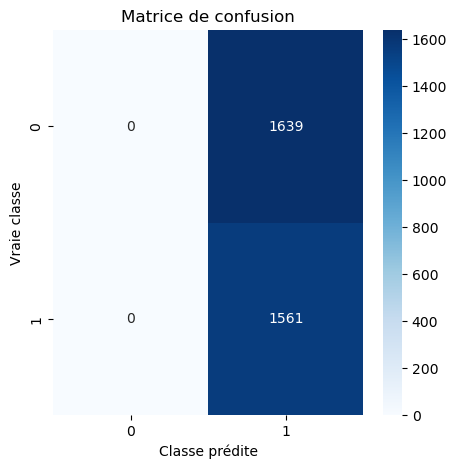

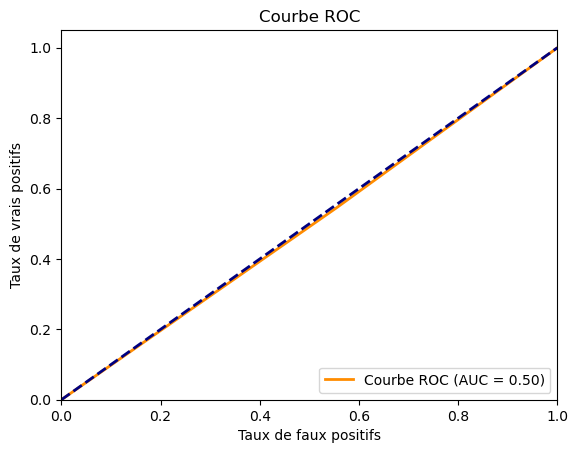

2024/12/23 17:29:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpw1udtlmj/model/tf2model/assets


INFO:tensorflow:Assets written to: /tmp/tmpw1udtlmj/model/tf2model/assets


In [ ]:
# --- Échantillonnage de 10% des données d'entraînement ---
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, train_size=0.1, stratify=y_train
)

# Créer et entraîner le modèle DistilBERT
model_distilbert, tokenizer = create_distilbert_model("distilbert-base-uncased")

# Tokenizer les tweets d'entraînement (échantillon) et de test
X_train_distilbert = tokenizer(X_train_small.tolist(), padding=True, truncation=True, return_tensors="tf")
X_test_distilbert = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="tf")

# Convertir les labels en tenseurs (échantillon et test)
y_train_distilbert = tf.convert_to_tensor(y_train_small)
y_test_distilbert = tf.convert_to_tensor(y_test)


# Hyperparamètres
batch_size = 8  # Vous pouvez ajuster
epochs = 3      # Vous pouvez ajuster

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle (sur l'échantillon)
        history = model_distilbert.fit(
            x={"input_ids": X_train_distilbert["input_ids"],
               "attention_mask": X_train_distilbert["attention_mask"]},
            y=y_train_distilbert,
            validation_split=0.2,  # Utiliser une partie de l'échantillon pour la validation
            epochs=epochs,
            batch_size=batch_size,
        )

        # Évaluer le modèle (sur l'ensemble de test *complet*)
        accuracy, precision, recall, f1, predict_time = evaluer_modele_bert(
            model_distilbert,
            {"input_ids": X_test_distilbert["input_ids"], "attention_mask": X_test_distilbert["attention_mask"]},
            y_test_distilbert
        )
    except KeyboardInterrupt:
      print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "DistilBERT")
    mlflow.log_param("model_name", "distilbert-base-uncased")
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", 5e-5)
    mlflow.log_param("train_size", 0.1)  # Log the training set size

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "DistilBERT")
    mlflow.set_tag("train_size", "10%")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_distilbert, "model_distilbert")

### 3.7 - USE

In [12]:
#@title 3.6 Entraînement et évaluation du modèle USE avec MLflow

import mlflow
import mlflow.keras
import tensorflow_hub as hub

# Charger le modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Encoder les tweets
X_train_use = embed(X_train)
X_test_use = embed(X_test)

# Créer le modèle USE
model_use = model.create_use_model(input_shape=(X_train_use.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_use.fit(X_train_use, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_use, X_test_use, y_test)

    # Enregistrer les paramètres
    # (Ajouter ici les paramètres du modèle USE)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "USE")
    
    # Enregistrer le modèle
    mlflow.keras.log_model(model_use, "model_use")

ModuleNotFoundError: No module named 'tensorflow_hub'

## 4. Comparaison des modèles

In [3]:
#@title Comparaison des modèles avec MLflow

import mlflow

# Fonction pour récupérer les métriques d'une exécution MLflow
def get_metrics_from_mlflow(model_name):
    # Rechercher l'exécution avec le tag "model_name"
    runs = mlflow.search_runs(filter_string=f"tag.model_name = '{model_name}'")
    if runs.empty:
        raise ValueError(f"Aucune exécution trouvée avec le tag 'model_name' = '{model_name}'")

    # Récupérer les métriques de la dernière exécution
    last_run = runs.iloc[-1]
    return (last_run["metrics.accuracy"], 
            last_run["metrics.precision"],
            last_run["metrics.recall"],
            last_run["metrics.f1_score"], 
            last_run["metrics.predict_time"])

# Comparaison des modèles
noms_modeles = ['LogisticRegression', 'MLP', 'LSTM_w2v', 'LSTM_ft', 'CNN', 'BERT', 'USE']

# Calculer les métriques pour chaque modèle
resultats = []
for model_name in noms_modeles:
    resultats.append(get_metrics_from_mlflow(model_name))

# Créer un DataFrame pour afficher les résultats
comparaison = pd.DataFrame(resultats, columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'Predict Time'], index=noms_modeles)

# Afficher les résultats
print(comparaison)

                    Accuracy  Precision    Recall  F1-score  Predict Time
LogisticRegression  0.587500   0.573881  0.599616  0.586466      0.008964
MLP                 0.587187   0.562370  0.693145  0.620947      0.373484
LSTM_w2v            0.528438   0.535135  0.253684  0.344198      5.080245
LSTM_ft             0.512188   0.500000  0.131326  0.208016      6.722547
CNN                 0.575000   0.551831  0.685458  0.611429      0.603637
BERT                0.431250   0.431250  1.000000  0.602620     19.545306
USE                 0.687500   0.620253  0.710145  0.662162      0.147319
